<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/algorithm/RANSAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 直線フィッティング

誤差分布は外れ値が大きいコーシー分布

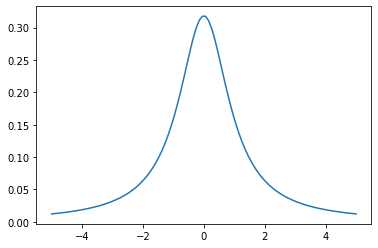

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def cauchy(x: np.ndarray):
    return 1/np.pi/(1+x*x)

x = np.linspace(-5, 5, 100)
y = cauchy(x)

plt.plot(x, y)
plt.show()

サンプルデータ生成

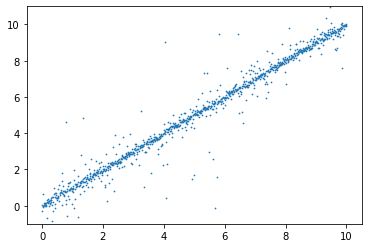

In [2]:
point_num: int = 1000

errors = np.random.standard_cauchy(point_num)
x = np.linspace(0, 10, point_num)
y = x + errors / 10

points = np.vstack([x, y]).T

plt.scatter(x, y, s=0.5)
plt.ylim(-1, 11)
plt.show()

ランダムサンプリング

In [3]:
index_mat = np.random.randint(0, point_num, (point_num, 2))
print(index_mat)

[[104 832]
 [ 16 199]
 [480 412]
 ...
 [310 220]
 [885 346]
 [415 514]]


In [4]:
np.array([x[index_mat], y[index_mat]]).shape

(2, 1000, 2)

In [5]:
# 転置前の成分数は (axis, trials, points)
# 転置後の成分数は (trials, points, axis)
samples_tensor = np.array([x[index_mat], y[index_mat]]).transpose(1, 2, 0)

print(samples_tensor.shape)
print(samples_tensor)

(1000, 2, 2)
[[[1.04104104 1.9506555 ]
  [8.32832833 8.8963379 ]]

 [[0.16016016 0.28605577]
  [1.99199199 1.92159496]]

 [[4.8048048  4.79610383]
  [4.12412412 4.18038537]]

 ...

 [[3.1031031  3.07455386]
  [2.2022022  2.19473768]]

 [[8.85885886 8.8223113 ]
  [3.46346346 3.53818362]]

 [[4.15415415 4.61748383]
  [5.14514515 5.15045447]]]


傾きと切片計算

In [6]:
params_tensor = np.array([np.polyfit(sample[:, 0], sample[:, 1], 1) 
                          for sample in samples_tensor])

<ipython-input-6-1062ae56eb9f>:1: RankWarning: Polyfit may be poorly conditioned
  params_tensor = np.array([np.polyfit(sample[:, 0], sample[:, 1], 1)


inlier の数を計算 → 最も良い候補を選択

In [7]:
def polynomial(params, points):
    max_degree = len(params)
    # shape=(params, points)
    terms = np.array([params[degree] * points[:, 0] ** (max_degree - degree - 1)
                      for degree in range(max_degree)])
    return np.sum(terms, axis=0)

def get_distances(params, points):
    y_est = polynomial(params, points)
    distances = np.abs(points[:, 1] - y_est)
    return distances

distances_tensor = np.array([
    get_distances(params, points) for params in params_tensor])

distance_th = 0.3
inlier_bool_tensor = np.array([
    distances < distance_th
    for distances in distances_tensor
])
inlier_num_array = np.array([
    np.sum(inlier_bool)
    for inlier_bool in inlier_bool_tensor
])

best_idx = np.argmax(inlier_num_array)
print(best_idx)

170


結果を確認

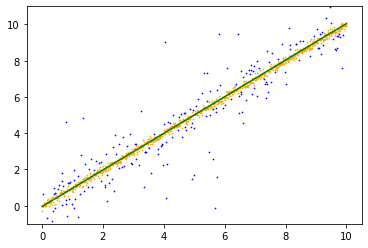

In [8]:
params = params_tensor[best_idx]
inlier_idx = np.arange(point_num)[inlier_bool_tensor[best_idx]]
outlier_idx = np.arange(point_num)[~inlier_bool_tensor[best_idx]]

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")

plt.plot(points[:, 0], polynomial(params, points),
         color="green")
plt.ylim(-1, 11)
plt.show()

再フィッティング

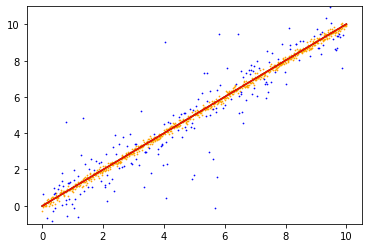

In [9]:
refined_params = np.polyfit(points[inlier_idx, 0], points[inlier_idx, 1], 1)

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")

plt.plot(points[:, 0], polynomial(refined_params, points), color="green")
plt.plot(points[:, 0], polynomial(refined_params, points), color="red")
plt.ylim(-1, 11)
plt.show()

## 2次曲線フィッティング

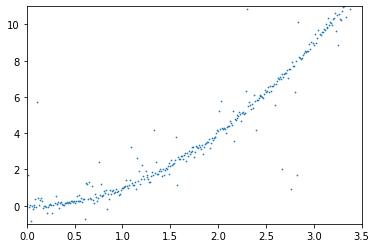

In [10]:
point_num: int = 1000

errors = np.random.standard_cauchy(point_num)
x = np.linspace(0, 10, point_num)
y = x**2 + errors / 10

points = np.vstack([x, y]).T

plt.scatter(x, y, s=0.5)
plt.xlim(0, 3.5)
plt.ylim(-1, 11)
plt.show()

In [11]:
index_mat = np.random.randint(0, point_num, (point_num, 3))

# 転置前の成分数は (axis, trials, points)
# 転置後の成分数は (trials, points, axis)
samples_tensor = np.array([x[index_mat], y[index_mat]]).transpose(1, 2, 0)
print(samples_tensor.shape)

(1000, 3, 2)


In [12]:
params_tensor = np.array([
    np.polyfit(sample[:, 0], sample[:, 1], 2)
    for sample in samples_tensor])

In [13]:
def get_distances(params, points):
    y_est =  params[0] * points[:, 0] **2 + params[1] * points[:, 0] + params[2]
    distances = np.abs(points[:, 1] - y_est)
    return distances

distances_tensor = np.array([
    get_distances(params, points) for params in params_tensor])

distance_th = 0.3
inlier_bool_tensor = np.array([
    distances < distance_th
    for distances in distances_tensor
])
inlier_num_array = np.array([
    np.sum(inlier_bool)
    for inlier_bool in inlier_bool_tensor
])

best_idx = np.argmax(inlier_num_array)
print(best_idx)

400


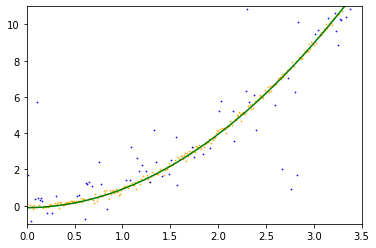

In [14]:
params = params_tensor[best_idx]
inlier_idx = np.arange(point_num)[inlier_bool_tensor[best_idx]]
outlier_idx = np.arange(point_num)[~inlier_bool_tensor[best_idx]]

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")

y_est =  params[0] * points[:, 0] **2 + params[1] * points[:, 0] + params[2]
plt.plot(points[:, 0], y_est, color="green")
plt.xlim(0, 3.5)
plt.ylim(-1, 11)
plt.show()

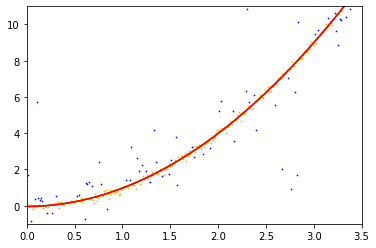

In [17]:
refined_params = np.polyfit(points[inlier_idx, 0], points[inlier_idx, 1], 2)
y_refined =  refined_params[0] * points[:, 0] **2 + params[1] * points[:, 0] + params[2]

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")


plt.plot(points[:, 0], polynomial(refined_params, points), color="green")
plt.plot(points[:, 0], polynomial(refined_params, points), color="red")
plt.xlim(0, 3.5)
plt.ylim(-1, 11)
plt.show()